In [1]:
import sys
sys.path.append('..')

import optimus
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

from utilities import FiniteDifference, RectangularPulse, TurkPulse

In [3]:
frequency = 500e3
radius_of_curvature = 0.064
radius = radius_of_curvature / 2
location = (0, 0, 0)
velocity = 1
source = optimus.source.create_bowl(frequency, outer_radius=radius, radius_of_curvature=radius_of_curvature, 
                                    location=location, source_axis=(0, 0, 1), velocity=velocity)

In [4]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

c_0 = material_ext.speed_of_sound
rho_0 = material_ext.density
C_t = material_ext.heat_capacity 
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b 
alpha_0 = material_ext.attenuation_coeff_a 

In [5]:
Nx = 51
Ny = 51
Nz = 101

xmin, xmax, ymin, ymax, zmin, zmax = [-0.03, 0.03, -0.03, 0.03, 0, 0.12]

delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

In [6]:
%%time

save_p = []

for i in range(Nz):
    zval = i * delta_z 
    plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
    points = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        zval*np.ones(plot_grid[0].size)))
    
    inc_field = transducer_field(source, material_ext, points, verbose=False)
    incident_pressure = inc_field.pressure.reshape([Nx, Ny])
    
    incident_pressure_plot = optimus.postprocess.common.array_to_imshow(incident_pressure)
    save_p.append(incident_pressure_plot)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
CPU times: user 9h 36min 25s, sys: 1.94 s, total: 9h 36min 27s
Wall time: 1h 13min 32s


In [7]:
save_p_2 = [np.abs(i) for i in save_p]
arr = np.array(save_p_2)
arr_reshaped = arr.reshape(arr.shape[0], -1)
np.savetxt('HEAD_1ms.txt', arr_reshaped)

In [54]:
IPP_abs_load = np.loadtxt("HEAD.txt")

IPP_abs = IPP_abs_load.reshape(
    IPP_abs_load.shape[0], IPP_abs_load.shape[1] // 51, 51) 

In [55]:
intensity = (IPP_abs)**2 / (2 * c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
heat_deposition = intensity.copy()
heat_deposition = 2 * alpha * intensity

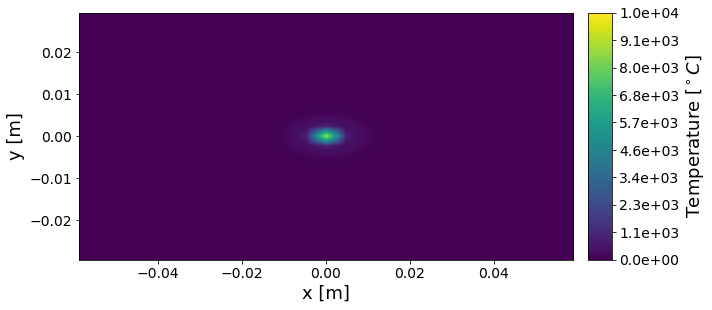

In [69]:
midpoint = heat_deposition[49]
fig = surface_plot(midpoint,
                   axes_lims=(delta_x * (-50), delta_x * (50), 
                              delta_y * (-25), delta_y * (25)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[0, 10241],
                   colorbar_unit="Temperature [$^\circ C$]",
                   )

In [70]:
delta_t = 2e-5
Nt = int(1.5e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp_ramp = []
max_temp_rect = []
max_temp_noat = []

prev_temp_ramp = T_0
prev_temp_rect = T_0
prev_temp_noat = T_0

time_domain = np.array(range(Nt)) * delta_t
rect_pulses = RectangularPulse(time_domain)
ramp_pulses = TurkPulse(time_domain)

In [71]:
%%time
for i in range(Nt):
    max_temp_ramp.append(np.max(prev_temp_ramp))
    max_temp_rect.append(np.max(prev_temp_rect))
    max_temp_noat.append(np.max(prev_temp_noat))
    
    prev_temp_ramp = FiniteDifference(temp_grid=prev_temp_ramp, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=ramp_pulses[i],
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)
    
    prev_temp_rect = FiniteDifference(temp_grid=prev_temp_rect, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=rect_pulses[i],
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)
    
    prev_temp_noat = FiniteDifference(temp_grid=prev_temp_noat, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=1,
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)

CPU times: user 14min 35s, sys: 0 ns, total: 14min 35s
Wall time: 14min 35s


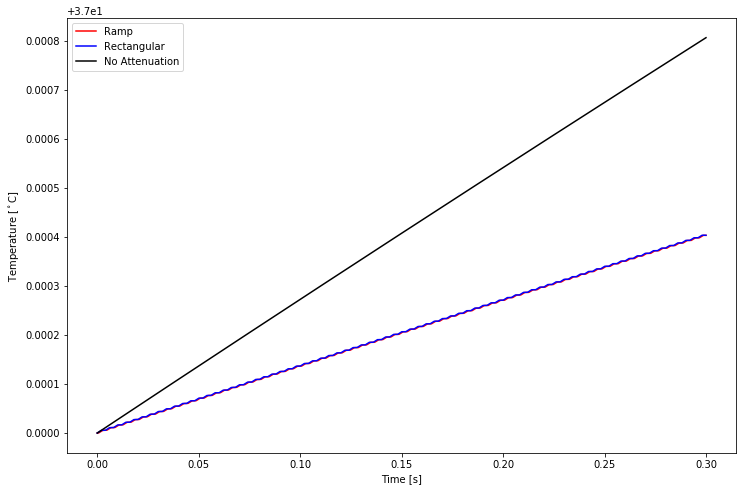

In [73]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain, max_temp_ramp, c='red', label = 'Ramp')
plt.plot(time_domain, max_temp_rect, c='blue', label = 'Rectangular')
plt.plot(time_domain, max_temp_noat, c='black', label = 'No Attenuation')

#plt.xlim(0.29, 0.3)
#plt.ylim(40.6, 40.9)
plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

In [74]:
delta_t_2 = 2e-2
Nt_2 = int(4e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp_noat_2 = []

prev_temp_noat_2 = T_0

time_domain_2 = np.array(range(Nt_2)) * delta_t_2

In [75]:
%%time
for i in range(Nt_2):
    max_temp_noat_2.append(np.max(prev_temp_noat_2))
    
    prev_temp_noat_2 = FiniteDifference(temp_grid=prev_temp_noat_2, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=1,
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t_2)

CPU times: user 12min 52s, sys: 0 ns, total: 12min 52s
Wall time: 12min 59s


Text(0, 0.5, 'Temperature [$^\\circ$C]')

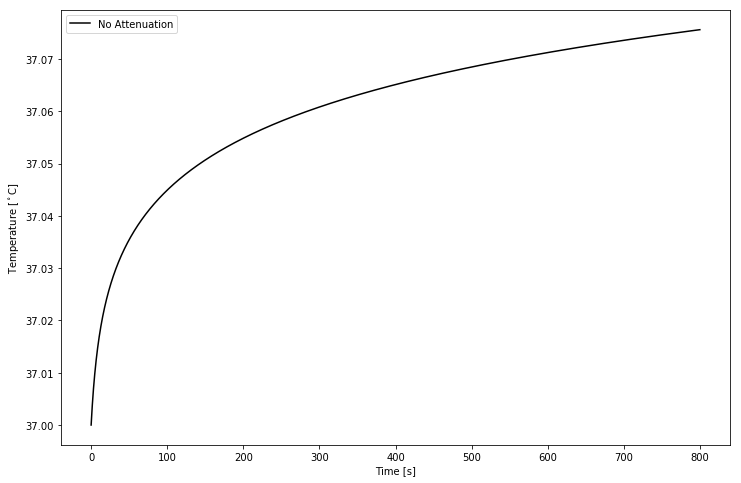

In [76]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain_2, max_temp_noat_2, c='black', label = 'No Attenuation')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')

In [77]:
%%time
for i in range(Nt_2):
    max_temp_noat_2.append(np.max(prev_temp_noat_2))
    
    prev_temp_noat_2 = FiniteDifference(temp_grid=prev_temp_noat_2, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=0,
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t_2)

CPU times: user 13min 40s, sys: 4.09 ms, total: 13min 40s
Wall time: 13min 40s


In [79]:
time_domain_2 = np.array(range(Nt_2 * 2)) * delta_t_2

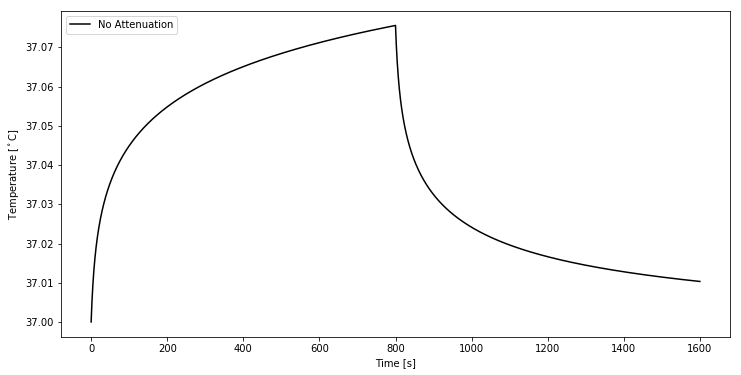

In [84]:
fig = plt.figure(figsize = (12,6))

plt.plot(time_domain_2, max_temp_noat_2, c='black', label = 'No Attenuation')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()